In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.6 MB/s eta 0:00:00


In [4]:
import cv2 as cv
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [5]:
img = cv.imread("/content/drive/MyDrive/Recognition/dataset/yayak/depan.jpeg")
# opencv BGR channel format and plt reads images as RGB channel format

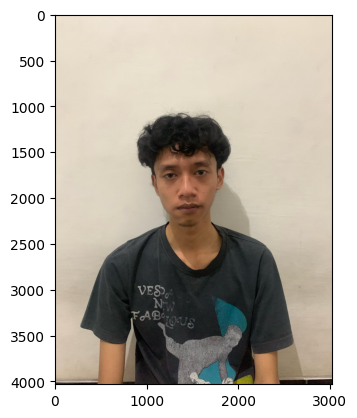

In [6]:
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img) # RGB

In [7]:
!pip install lz4

In [8]:
from mtcnn.mtcnn import MTCNN

detector = MTCNN()
results = detector.detect_faces(img)

In [9]:
results

[{'box': [1066, 1389, 706, 929],
  'confidence': np.float64(0.9998613595962524),
  'keypoints': {'nose': [np.int64(1435), np.int64(1951)],
   'mouth_right': [np.int64(1584), np.int64(2098)],
   'right_eye': [np.int64(1583), np.int64(1727)],
   'left_eye': [np.int64(1265), np.int64(1752)],
   'mouth_left': [np.int64(1328), np.int64(2121)]}}]

In [10]:
x,y,w,h = results[0]['box']

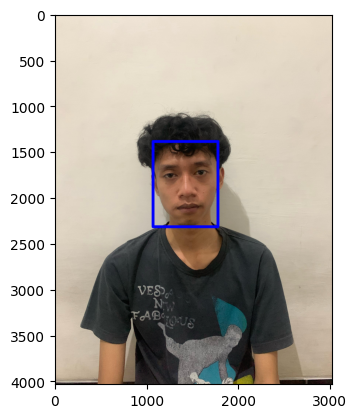

In [11]:
img = cv.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 30)
plt.imshow(img)

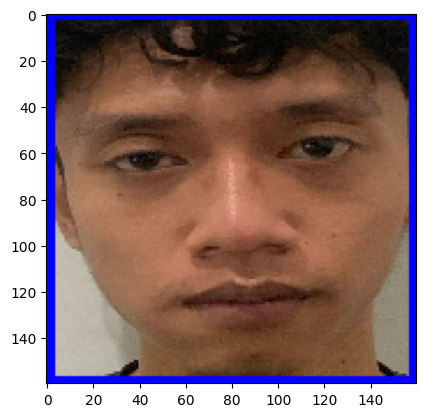

In [12]:
my_face = img[y:y+h, x:x+w]
#Facenet takes as input 160x160
my_face = cv.resize(my_face, (160,160))
plt.imshow(my_face)

array([[[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       ...,

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]],

       [[  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255],
        ...,
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0, 255]]], dtype=uint8)
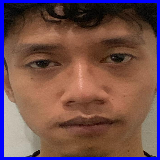

In [13]:
my_face

# Automate the preprocessing


In [14]:
class FACELOADING:
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160,160)
        self.X = []
        self.Y = []
        self.detector = MTCNN()


    def extract_face(self, filename):
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        x,y,w,h = self.detector.detect_faces(img)[0]['box']
        x,y = abs(x), abs(y)
        face = img[y:y+h, x:x+w]
        face_arr = cv.resize(face, self.target_size)
        return face_arr


    def load_faces(self, dir):
        FACES = []
        for im_name in os.listdir(dir):
            try:
                path = dir + im_name
                single_face = self.extract_face(path)
                FACES.append(single_face)
            except Exception as e:
                pass
        return FACES

    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = self.directory +'/'+ sub_dir+'/'
            FACES = self.load_faces(path)
            labels = [sub_dir for _ in range(len(FACES))]
            print(f"Loaded successfully: {len(labels)}")
            self.X.extend(FACES)
            self.Y.extend(labels)

        return np.asarray(self.X), np.asarray(self.Y)


    def plot_images(self):
        plt.figure(figsize=(18,16))
        for num,image in enumerate(self.X):
            ncols = 3
            nrows = len(self.Y)//ncols + 1
            plt.subplot(nrows,ncols,num+1)
            plt.imshow(image)
            plt.axis('off')

In [15]:
faceloading = FACELOADING("/content/drive/MyDrive/Recognition/dataset")
X, Y = faceloading.load_classes()

Loaded successfully: 10
Loaded successfully: 10
Loaded successfully: 10
Loaded successfully: 9
Loaded successfully: 10
Loaded successfully: 12


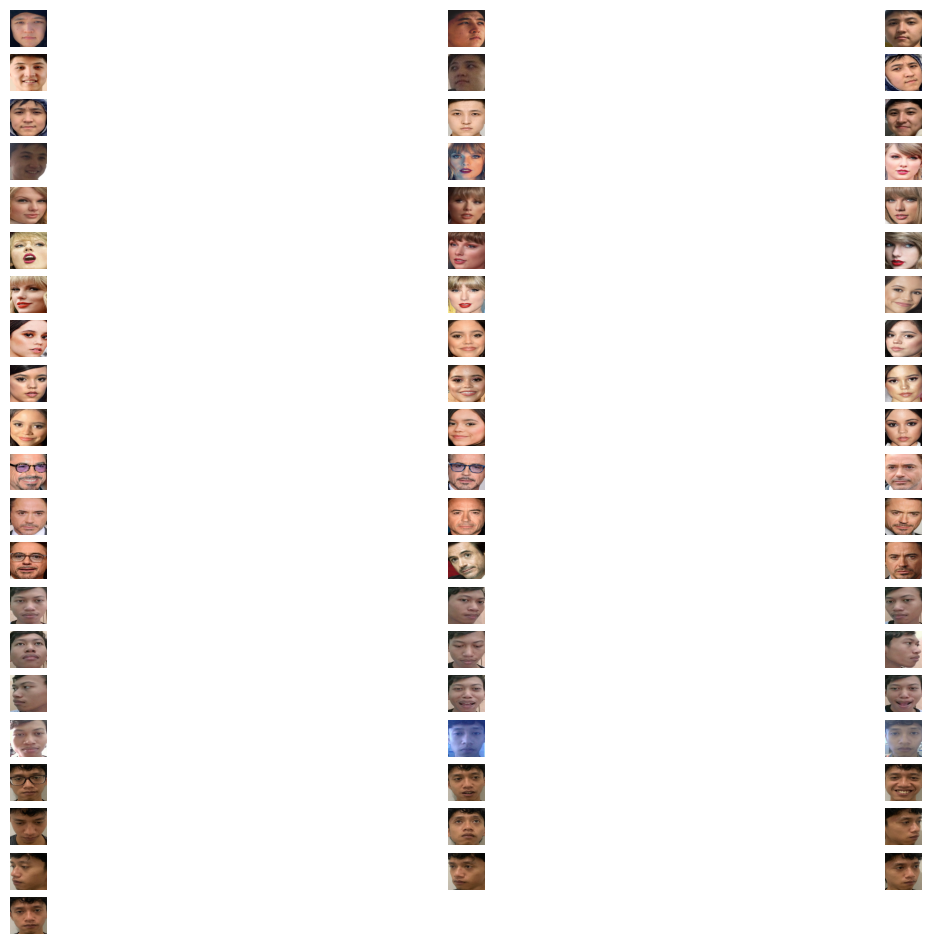

In [16]:
plt.figure(figsize=(16,12))
for num,image in enumerate(X):
    ncols = 3
    nrows = len(Y)//ncols + 1
    plt.subplot(nrows,ncols,num+1)
    plt.imshow(image)
    plt.axis('off')

# FaceNet part

In [17]:
!pip install keras-facenet

  Preparing metadata (setup.py) ... done
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10367 sha256=c5e7b6afcaea97a0c33deb2ceb99a096d69f2a308124b6e9f95ecc0dd01662eb
  Stored in directory: /root/.cache/pip/wheels/99/94/dd/cb1a65a7440ba6d508bd24346c15af0b1d24ff8b1cdb1c9959
Successfully built keras-facenet


In [18]:
from keras_facenet import FaceNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

# Load model FaceNet asli
base_model = FaceNet()

# Buat model baru dengan output 128 dimensi
input_layer = Input(shape=(160, 160, 3))
base_embeddings = base_model.model(input_layer)
embeddings_128d = Dense(128, activation=None, name='embeddings_128d')(base_embeddings)

# Buat model baru
model_128d = Model(inputs=input_layer, outputs=embeddings_128d)

# Fungsi untuk mendapatkan embedding 128d
def get_embedding_128d(face_img):
    face_img = face_img.astype('float32')
    face_img = np.expand_dims(face_img, axis=0)
    yhat = model_128d.predict(face_img)
    return yhat[0]  # 128D image (1x128)

In [19]:
EMBEDDED_X = []

for img in X:
    EMBEDDED_X.append(get_embedding_128d(img))

EMBEDDED_X = np.asarray(EMBEDDED_X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [ ]:
np.savez_compressed('faces_embeddings_done_4classes.npz', EMBEDDED_X, Y)

# SVM model


In [37]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

Text(0, 0.5, '3')

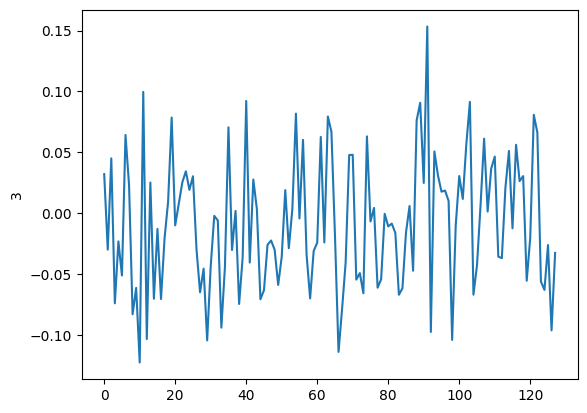

In [38]:
plt.plot(EMBEDDED_X[0])
plt.ylabel(Y[0])

In [39]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
# Cek dimensi (tetap pertahankan)
print(EMBEDDED_X.shape)
print(Y.shape)
# Sesuaikan Y jika perlu (tetap pertahankan)
if EMBEDDED_X.shape[0] < Y.shape[0]:
    Y = Y[:EMBEDDED_X.shape[0]]

# Definisikan parameter yang akan diuji
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10],
    'kernel': ['rbf', 'linear', 'poly']
}

# Siapkan k-fold cross validation (misalnya 5-fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

(61, 128)
(61,)


In [40]:
from sklearn.svm import SVC
# Buat model GridSearchCV
grid_search = GridSearchCV(
    estimator=SVC(probability=True),
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1  # Gunakan semua core yang tersedia
)

# Latih model dengan grid search
grid_search.fit(EMBEDDED_X, Y)

# Tampilkan hasil terbaik
print("Parameter terbaik:")
print(grid_search.best_params_)
print("\nSkor akurasi terbaik:")
print(grid_search.best_score_)

# Ambil model terbaik
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 147 candidates, totalling 735 fits
Parameter terbaik:
{'C': 100, 'gamma': 10, 'kernel': 'rbf'}

Skor akurasi terbaik:
0.6730769230769231


=== EVALUASI MODEL TERBAIK ===
Akurasi: 1.0000

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00        10
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        12

    accuracy                           1.00        61
   macro avg       1.00      1.00      1.00        61
weighted avg       1.00      1.00      1.00        61



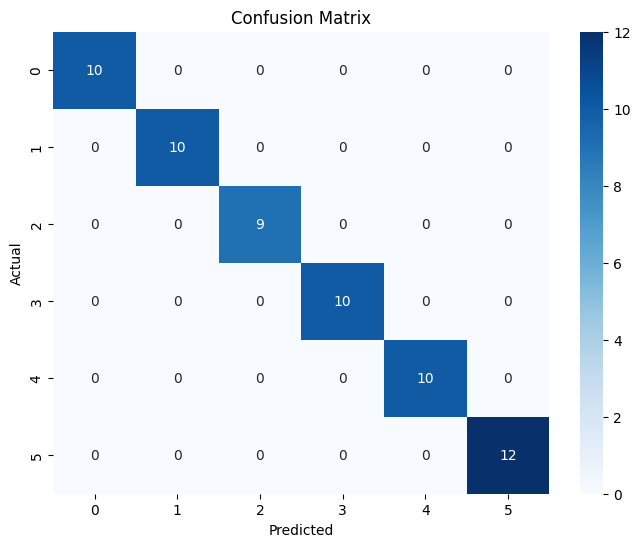


Distribusi Kelas:
Aktual: 0    10
1    10
2     9
3    10
4    10
5    12
Name: count, dtype: int64
Prediksi: 0    10
1    10
2     9
3    10
4    10
5    12
Name: count, dtype: int64


In [41]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Prediksi dengan model terbaik
y_pred = best_model.predict(EMBEDDED_X)

print("=== EVALUASI MODEL TERBAIK ===")
print(f"Akurasi: {accuracy_score(Y, y_pred):.4f}")
print("\nLaporan Klasifikasi:")
print(classification_report(Y, y_pred))

# Confusion Matrix
cm = confusion_matrix(Y, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Tampilkan distribusi prediksi
print("\nDistribusi Kelas:")
print("Aktual:", pd.Series(Y).value_counts().sort_index())
print("Prediksi:", pd.Series(y_pred).value_counts().sort_index())

In [44]:
import cv2 as cv
t_im = cv.imread("/content/drive/MyDrive/Recognition/yayak_test.jpg")
t_im = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
x,y,w,h = detector.detect_faces(t_im)[0]['box']

In [49]:
t_im = t_im[y:y+h, x:x+w]
t_im = cv.resize(t_im, (160,160))
test_im = get_embedding_128d(t_im)

InvalidArgumentError: Graph execution error:

Detected at node functional_1/inception_resnet_v1_1/Conv2d_2a_3x3_1/convolution defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-49-8d8b169c09f1>", line 3, in <cell line: 0>

  File "<ipython-input-18-9ec0f539ac5c>", line 20, in get_embedding_128d

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 562, in predict

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 259, in one_step_on_data_distributed

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 249, in one_step_on_data

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 104, in predict_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 908, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 182, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 637, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 908, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 182, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 637, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 908, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py", line 243, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py", line 233, in convolution_op

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py", line 1305, in conv

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py", line 331, in conv

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py", line 304, in _conv

Computed output size would be negative: -2 [input_size: 0, effective_filter_size: 3, stride: 1]
	 [[{{node functional_1/inception_resnet_v1_1/Conv2d_2a_3x3_1/convolution}}]] [Op:__inference_one_step_on_data_distributed_76523]

In [ ]:
test_im = [test_im]
ypreds = best_model.predict(test_im)

In [ ]:
ypreds

In [ ]:
encoder.inverse_transform(ypreds)

In [ ]:
import pickle
# Simpan model terbaik
with open('svm_model_best_params.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Simpan juga encoder untuk penggunaan nanti
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Visualisasi hasil grid search sebagai heatmap
results = pd.DataFrame(grid_search.cv_results_)
scores = np.array(results.mean_test_score).reshape(len(param_grid['C']), len(param_grid['gamma']))

plt.figure(figsize=(10, 8))
sns.heatmap(
    scores,
    annot=True,
    xticklabels=param_grid['gamma'],
    yticklabels=param_grid['C'],
    cmap='viridis'
)
plt.xlabel('Gamma')
plt.ylabel('C')
plt.title('Akurasi Cross-Validation untuk Kombinasi Parameter')
plt.show()

# Buat confusion matrix untuk model terbaik
cm = confusion_matrix(Y, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediksi')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix')
plt.show()